In [3]:
!pip install gym pyvirtualdisplay 
!pip install pygame gymnasium[classic-control] pyvirtualdisplay
!pip install --upgrade setuptools 


<h2> Importing dependencies and define helper functions </h2>

In [4]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [7]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [8]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [9]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [45]:
observation, _ = env.reset()
print("Initial observations:", observation)

Initial observations: [0.01709724 0.02757332 0.01319743 0.04149739]


<h4> Observation = [cart position, cart velocity, pole angle, pole angular velocity] </h4>

For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [12]:
print(env.step(0))

(array([-0.03242591, -0.373014  , -0.03261142,  0.54865456], dtype=float32), 1.0, False, False, {})


In [59]:
observation, reward, done, _, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.33107588 -2.6991177   0.5986238   4.7351556 ]
Reward for this step: 0.0
Is this round done? True


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [74]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, _, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [ ]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

For Task 1, we can show the observation and chosen action below:

In [ ]:
observation, _ = env.reset()
action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.01777253 -0.02463525 -0.02999895  0.0492132 ]
Chosen action: 1


In [ ]:
observation, _ = env.reset()
cumulative_reward = 0
done = False
while not done:
    action = rand_policy_agent(observation)
    observation, reward, done, _, info = env.step(action)
    cumulative_reward += reward
    print("Observation:", observation)
    print("Chosen action:", action)
print("Cumulative reward for this round:", cumulative_reward)

Observation: [-0.03306764 -0.19924793 -0.02260402  0.27338678]
Chosen action: 0
Observation: [-0.0370526  -0.39404017 -0.01713628  0.5588555 ]
Chosen action: 0
Observation: [-0.0449334  -0.19868194 -0.00595917  0.26082334]
Chosen action: 1
Observation: [-0.04890704 -0.00347542 -0.0007427  -0.03373322]
Chosen action: 1
Observation: [-0.04897655 -0.19858672 -0.00141737  0.2587153 ]
Chosen action: 0
Observation: [-0.05294828 -0.3936884   0.00375694  0.5509508 ]
Chosen action: 0
Observation: [-0.06082205 -0.19861943  0.01477595  0.25945395]
Chosen action: 1
Observation: [-0.06479444 -0.39394915  0.01996503  0.55676055]
Chosen action: 0
Observation: [-0.07267343 -0.58934563  0.03110024  0.85566616]
Chosen action: 0
Observation: [-0.08446033 -0.78487724  0.04821357  1.1579638 ]
Chosen action: 0
Observation: [-0.10015788 -0.5904157   0.07137284  0.8807797 ]
Chosen action: 1
Observation: [-0.11196619 -0.78643084  0.08898844  1.1950197 ]
Chosen action: 0
Observation: [-0.12769482 -0.5925666   0

## Task 1: Development of an RL agent

<h3> A Q-learning agent shall be used  <br>
<h5> Q-learning works with finite (discrete) state spaces, but CartPole’s state is continuous, meaning there are infinite possible states. <br>
The agent can’t store Q-values for infinite states, so we must discretize the state space into bins. </h5>


In [215]:
# Define state space boundaries
state_bounds = np.array([
    [-4.8, 4.8],   # Cart Position
    [-5.0, 5.0],   # Cart Velocity 
    [-0.418, 0.418],  # Pole Angle (~24 degrees)
    [-5.0, 5.0]    # Pole Angular Velocity 
])

# Number of discrete bins
num_bins = [40, 40, 50, 50]

# Compute bin size for each variable
bin_size = (state_bounds[:, 1] - state_bounds[:, 0]) / num_bins

def get_discrete_state(state):
    
    # Clip state values to prevent out-of-range errors
    normalized_state = np.clip(state, state_bounds[:, 0] * 2, state_bounds[:, 1] * 2)
    discrete_state = ((normalized_state - state_bounds[:, 0]) / bin_size).astype(int)
    
    return tuple(discrete_state)

In [155]:
# Check initial state
observation, _ = env.reset()
discrete_obs = get_discrete_state(observation)
print("Continuous state:", observation)
print("Discrete state:", discrete_obs)

Continuous state: [ 0.04314561  0.01128179 -0.0194289  -0.00549483]
Discrete state: (20, 20, 23, 24)


<h5> The observations for the current continuous state will be saved into the respective bins indicated in the discrete state tuple 

In [216]:
#Defining Hypermeters
LEARNING_RATE = 0.5  # alpha
DISCOUNT = 0.95  # gamma
EPISODES = 100

epsilon = 1
epsilon_min = 0.05
epsilon_decay = 0.95



In [ ]:
# Q-table initialization
q_table = np.zeros((num_bins + [env.action_space.n]))
q_table.shape

# Reward array initialization
rewardArr = np.zeros((EPISODES + 1,), dtype=int)

<h5> We will be implementing epsilon-greedy policy for action selection 

In [207]:
def agent(env, EPISODES, LEARNING_RATE, DISCOUNT, epsilon, epsilon_decay, q_table, epsilon_min=0.01):
    total_reward = 0
    prev_episode_reward = 0
    total_steps = np.zeros(10, dtype = int)
    
    for episode in range(EPISODES):
        # Reset the environment and get the initial state
        discrete_state = get_discrete_state(env.reset()[0])
        done = False
        episode_reward = 0
        episode_length = 0
        time_since_last_reward = 0  # Track time steps since last reward

        # Loop until the episode is complete
        while not done and episode_length < 500:
            # Determine the action to take using epsilon-greedy policy
            if np.random.random() > epsilon:
                action = np.argmax(q_table[discrete_state])
            else:
                action = np.random.randint(0, env.action_space.n)

            # Take the chosen action and observe the new state and reward
            new_state, reward, done, _, info = env.step(action)
            episode_reward += reward
            episode_length += 1
            time_since_last_reward += 1

            # Discretize the new state and find the maximum Q-value for the new state
            new_discrete_state = get_discrete_state(new_state)
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]

            # Reward shaping logic
            cart_position, cart_velocity, pole_angle, pole_velocity = new_state

            # Penalize large cart position deviation (increased penalty)
            if abs(cart_position) > 2.4:  # Cart position is out of bounds
                reward -= 2.0  # Increase the penalty

            # Penalize large pole angle deviation (increased penalty)
            if abs(pole_angle) > 0.3:  # Pole angle deviates too much from vertical
                reward -= 2.0  # Increase the penalty

            # Reward for stabilizing the pole (within a small angle range)
            if abs(pole_angle) < 0.05:
                reward += 0.3  # Larger reward for maintaining pole stability

            # Reward for keeping cart position within the center of track
            if abs(cart_position) < 0.5:
                reward += 0.2  # Larger reward for keeping cart near center

            # Reward for every 100 time steps (longer episode duration)
            if time_since_last_reward >= 100:
                reward += 0.5  # Give a larger reward for 100 time steps

            # Reward for every 200 time steps (further stabilization)
            if time_since_last_reward >= 200:
                reward += 1.0  # Larger reward for 200 time steps

            # Update the Q-value using the Q-learning update rule
            new_q = current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q - current_q)
            q_table[discrete_state + (action,)] = new_q

            # Update the current state to the new state
            discrete_state = new_discrete_state

        # Tracking the total episode reward and reward for each episode
        total_reward += episode_reward
        rewardArr[episode] = episode_reward
        total_steps[episode % 10] = episode_length

        # Update epsilon (exploration rate) with decay
        if epsilon > epsilon_min and episode_reward > prev_episode_reward:
            epsilon *= epsilon_decay

        prev_episode_reward = episode_reward

        # Print progress for every 10% of total episodes
        if episode == 0 or episode % (EPISODES // 10) == 0 or episode == EPISODES-1:
            print(f"Episode {episode}/{EPISODES} - Epsilon: {epsilon:.4f}")
            print("Max Steps:", max(total_steps))
            mean_reward = total_reward / (episode + 1)
            print(f"Mean Reward: {mean_reward:.2f}")
            
    # Closing the environment and returning the trained q_table and rewardArr
    env.close()
    return q_table, rewardArr


<h5> Epsilon gradually decays over time to shift from exploration to exploitation: <br>
- Epsilon only decreases if the agent's reward is improving, encouraging exploration when needed. <br>
- It stops decreasing at 0.05, ensuring the agent never stops exploring completely.

<h5> Since epsilon starts at 1 and gradually decreases over time, in early episodes, the agent explores more (choosing a random action frequently). As epsilon gets smaller, the agent exploits more (choosing the best-known action more often). This aligns with the ε-soft policy improvement shown in the image.

In [218]:
q_table, rewardArr = agent(env, EPISODES, LEARNING_RATE, DISCOUNT, epsilon, epsilon_decay, q_table)

Episode 0/100 - Epsilon: 0.9500
Max Steps: 14
Mean Reward: 14.00
Episode 10/100 - Epsilon: 0.7351
Max Steps: 69
Mean Reward: 31.82
Episode 20/100 - Epsilon: 0.5688
Max Steps: 94
Mean Reward: 40.71
Episode 30/100 - Epsilon: 0.4401
Max Steps: 119
Mean Reward: 41.74
Episode 40/100 - Epsilon: 0.3585
Max Steps: 120
Mean Reward: 49.05
Episode 50/100 - Epsilon: 0.2503
Max Steps: 146
Mean Reward: 56.69
Episode 60/100 - Epsilon: 0.1840
Max Steps: 247
Mean Reward: 65.87
Episode 70/100 - Epsilon: 0.1424
Max Steps: 271
Mean Reward: 74.86
Episode 80/100 - Epsilon: 0.0994
Max Steps: 286
Mean Reward: 79.77
Episode 90/100 - Epsilon: 0.0810
Max Steps: 215
Mean Reward: 86.38
Episode 99/100 - Epsilon: 0.0627
Max Steps: 500
Mean Reward: 100.78


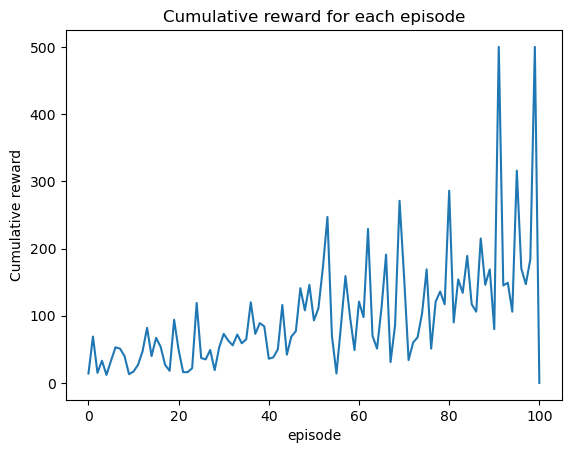

In [219]:
plt.plot(rewardArr)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [220]:
print("Average cumulative reward:", rewardArr.mean())
print("Is my agent good enough?", rewardArr.mean() > 195)

Average cumulative reward: 99.78217821782178
Is my agent good enough? False
